# Portfolio Analyzer overview

Portfolio Analyzer is a python library built to make easy portfolio analysis. In this Notebook we are going to see few examples. First things first. You can install Portfolio Analyzer with pip, so

In [1]:
#%%bash
#pip install git+https://github.com/Tokukawa/PortfolioAnalyzer.git

The first thing we need in order to analyze porfolio is data. We can use the function `yahoo2pandas`. This function take a list of tickers and return a pandas dataframe

In [2]:
from portfolio_analyzer.stocks_data_loader import yahoo2pandas

In [3]:
tickers = ['SPXL', 'TMF', 'UGL']
data = yahoo2pandas(tickers, frequency='daily')

In [4]:
data.head()

,SPXL,TMF,UGL
formatted_date,,,
2009-04-16,2.415000,14.5350,29.920000
2009-04-17,2.470000,13.8850,29.440001
2009-04-20,2.152500,14.7275,30.690001
2009-04-21,2.278333,14.2825,30.559999
2009-04-22,2.237500,13.7950,30.889999


By default `yahoo2pandas` return all possible data from yahoo. You can specify range of time you want and the frequency. Once we obtained the data, we can optimize our portfolio according to some most common algorithms. Up this moment you can use only `minimal_variance`, `risk_parity` and `approximated_max_kelly`.

In [5]:
from portfolio_analyzer.optimizers import approximated_max_kelly, minimal_variance, risk_parity

In [6]:
minimal_variance(data)

,SPXL,TMF,UGL
0,0.301519,0.347227,0.351254


In [7]:
risk_parity(data)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0211928867580408e-17
            Iterations: 19
            Function evaluations: 96
            Gradient evaluations: 19


,SPXL,TMF,UGL
0,0.312896,0.346134,0.34097


In [8]:
approximated_max_kelly(data)

,SPXL,TMF,UGL
0,0.307768,0.35065,0.341582


We can see how our portfolio would perform with `NaiveBackTest`.

In [9]:
from portfolio_analyzer.backtest import NaiveBackTest
from portfolio_analyzer.utils import portfolio2dic

In [10]:
my_portfolio = portfolio2dic(approximated_max_kelly(data))

In [11]:
backtest = NaiveBackTest(my_portfolio, data)

In [13]:
max_kelly_backtest = backtest.run()

We can perform some measures on the back test and we can plot it.

In [14]:
%matplotlib inline
from portfolio_analyzer.metrics import MainMetrics

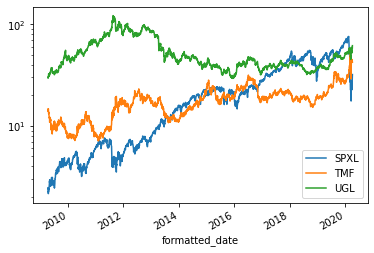

In [15]:
data.plot(logy=True)

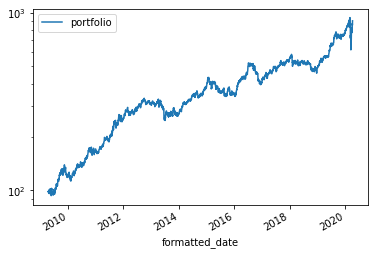

In [16]:
risk_parity_backtest.plot(logy=True)

In [17]:
benchmark_data = yahoo2pandas(['VTI'], frequency='daily')
measures = MainMetrics(benchmark=benchmark_data)

In [18]:
MainMetrics(benchmark_data).estimate(risk_parity_backtest)

,portfolio
alpha,0.146317
average arithmetic return,0.225526
average geometric return,0.223687
benchmark correlation,0.426000
beta,0.524348
max draw down,-0.341701
relative draw down,0.976281
relative return,2.001528
relative sharpe ratio,1.507573
relative variance,1.515327


But I want to perform a proper out-of-sample back test before rebalancing my portfolio. We can use the class `OutOfSampleBackTest`. First of all we need to know how many times we can split the dataset.

In [19]:
import pandas as pd
from portfolio_analyzer.utils import factors

Before starting my out of sample back test I neee to know how many eway I can split my data. I can know it with `factors` function 

In [20]:
factors(len(data))

[1, 2, 3, 6, 461, 922, 1383, 2766]

I can split my data in all the factors shown above!

In [21]:
SPLITS = 461

Now we can make a proper outofsample backtest.

In [22]:
from portfolio_analyzer.backtest import OutOfSampleBackTest

In [23]:
oos_backtest = OutOfSampleBackTest(data, minimal_variance, SPLITS, past_blocks=3, method='asym-blocks')

In [24]:
out_of_sample_portfolio = oos_backtest.run()

In [25]:
MainMetrics(benchmark_data).estimate(out_of_sample_portfolio)

,portfolio
alpha,0.155059
average arithmetic return,0.227744
average geometric return,0.228361
benchmark correlation,0.361031
beta,0.402699
max draw down,-0.298444
relative draw down,0.852689
relative return,1.704849
relative sharpe ratio,1.422328
relative variance,1.248803


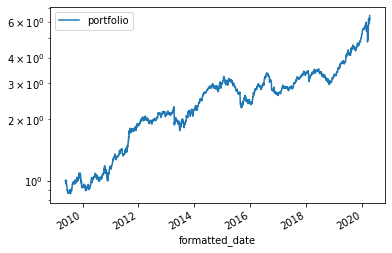

In [26]:
out_of_sample_portfolio.plot(logy=True)

I can even define my own strategy!

In [27]:
def custom_portfolio(data):
    return pd.DataFrame({'SPXL': [0.36], 'TMF':[0.48], 'UGL':[0.16]})

In [28]:
oos_backtest = OutOfSampleBackTest(data, custom_portfolio, SPLITS, past_blocks=4, method='asym-blocks')

In [29]:
out_of_sample_portfolio = oos_backtest.run()

We can get the actual out of sample performance the same way we did before.

In [30]:
MainMetrics(benchmark_data).estimate(out_of_sample_portfolio)

,portfolio
alpha,0.164662
average arithmetic return,0.227709
average geometric return,0.230817
benchmark correlation,0.337864
beta,0.361293
max draw down,-0.316818
relative draw down,0.905188
relative return,1.825512
relative sharpe ratio,1.560228
relative variance,1.142739


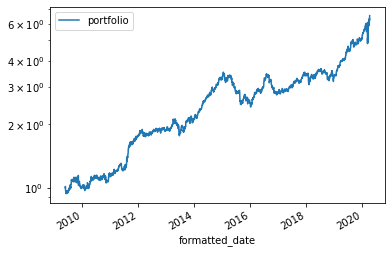

In [31]:
out_of_sample_portfolio.plot(logy=True)

I can even detect trends. For trend detection we can use the function l1filter.

In [32]:
from portfolio_analyzer.filtering import l1filter

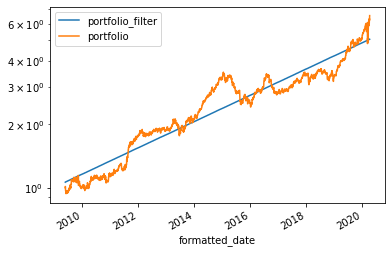

In [33]:
filtered, test = l1filter(out_of_sample_portfolio, delta=1E5)
filtered.plot(logy=True)

In [34]:
filtered.head()

,portfolio_filter,portfolio
formatted_date,,
2009-06-01,1.062476,1.000000
2009-06-02,1.063203,1.014136
2009-06-03,1.063931,1.003909
2009-06-04,1.064660,0.986861
2009-06-05,1.065389,0.967243


Whenever we perform a trend detection the test of stationarity is performed on the residuals. We can see the statistics as a pandas dataframe.

In [35]:
test['portfolio']

,portfolio
ADF Test Statistic,-1.606308
P-Value,0.480424
Lags Used,6.000000
Observations Used,2273.000000
Critical Value (1%),-3.433230
Critical Value (5%),-2.862812
Critical Value (10%),-2.567447


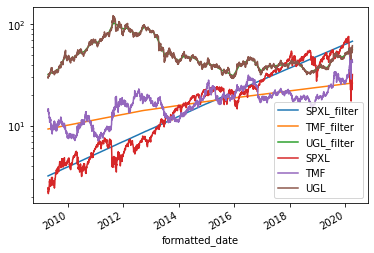

In [36]:
filtered, test = l1filter(data, delta=[1E4, 1E4, 1E1])
filtered.plot(logy=True)

In [37]:
test.keys()

dict_keys(['SPXL', 'TMF', 'UGL'])

In [38]:
test['SPXL']

,SPXL
ADF Test Statistic,-3.200844
P-Value,0.019936
Lags Used,25.000000
Observations Used,2740.000000
Critical Value (1%),-3.432739
Critical Value (5%),-2.862595
Critical Value (10%),-2.567332
